# Tugas Besar 1 IF3270 Pembelajaran Mesin

Group13 - K03:
1. 13522129 Hugo Sabam Augusto
2. 13522136 Muhammad Zaki
3. 13522137 Ahmad Rafi Maliki



## Import Libraries

In [1]:
from lib.MLP import *
from lib.Graph import *
from lib.Util import normalize, one_hot_encode

import random

import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Load mnist_784 dataset

In [2]:
start_time = time.time()

mnist = fetch_openml('mnist_784', version=1, parser='auto')

print(f"Data loaded in {time.time() - start_time:.2f} seconds")
print(f"Data shape: {mnist.data.shape}")

Data loaded in 4.19 seconds
Data shape: (70000, 784)


In [3]:
TRAIN_DATA_SIZE = 60000
TEST_SIZE = mnist.data.shape[0] - TRAIN_DATA_SIZE

X, y = mnist.data, mnist.target.astype(int)

X = normalize(X)
y = one_hot_encode(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)

print(f"Finished processing dataset {time.time() - start_time:.2f} seconds\n(1) {X_train.shape[0]} training samples\n(2) {X_test.shape[0]} test samples")

Finished processing dataset 8.26 seconds
(1) 60000 training samples
(2) 10000 test samples


In [5]:
# Define MLP layers
hidden_layer_1 = Layer(input_size=784, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=8, n_neurons=4, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
output_layer = Layer(input_size=4, n_neurons=10, activation='softmax', bias_init='zeros', seed=42, weight_init='he_uniform')

layers = [hidden_layer_1, hidden_layer_2, output_layer]

mlp = MLP(layers=layers, loss_function='cce', lr=0.01)

# Training model
mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=100, batch_size=100)

# Evaluasi di test set
test_acc = mlp.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}%")


Training: 100%|██████████| 100/100 [00:56<00:00,  1.76epoch/s, accuracy=91.94%, train_loss=0.2785, val_loss=0.3211]

Test Accuracy: 90.46%


In [5]:
print("\nEvaluating original model...")
original_predictions = mlp.predict(X_test[:100])
y_test_indices = np.argmax(y_test[:100], axis=1)
original_accuracy = accuracy_score(y_test_indices, original_predictions)
print(f"Original model accuracy: {original_accuracy:.4f}")

print("\nSaving model...")
save_path = 'mnist_model.pkl'
mlp.save(save_path)
print(f"Model saved to {save_path}")

print("\nLoading model...")
loaded_model = MLP.load(save_path)

print("\nValidating loaded model...")
loaded_predictions = loaded_model.predict(X_test[:100])
loaded_accuracy = accuracy_score(y_test_indices, loaded_predictions)
print(f"Loaded model accuracy: {loaded_accuracy:.4f}")

is_identical = np.array_equal(original_predictions, loaded_predictions)
print(f"\nPredictions identical: {is_identical}")

print("\nComparing model parameters:")
all_params_match = True

if len(mlp.layers) != len(loaded_model.layers):
    print(f"Different number of layers: {len(mlp.layers)} vs {len(loaded_model.layers)}")
    all_params_match = False
else:
    for i, (orig_layer, loaded_layer) in enumerate(zip(mlp.layers, loaded_model.layers)):
        weights_match = np.array_equal(orig_layer.weights, loaded_layer.weights)
        biases_match = np.array_equal(orig_layer.biases, loaded_layer.biases)
        
        if weights_match and biases_match:
            print(f"Layer {i}: All parameters match ✓")
        else:
            which_diff = []
            if not weights_match: which_diff.append("weights")
            if not biases_match: which_diff.append("biases")
            print(f"Layer {i}: Parameters differ ({', '.join(which_diff)}) ✗")
            all_params_match = False

print(f"\nOverall parameter comparison: {'PASSED' if all_params_match else 'FAILED'}")


Evaluating original model...
Original model accuracy: 0.8800

Saving model...
Model successfully saved to mnist_model.pkl
Model saved to mnist_model.pkl

Loading model...
Model successfully loaded from mnist_model.pkl

Validating loaded model...
Loaded model accuracy: 0.8800

Predictions identical: True

Comparing model parameters:
Layer 0: All parameters match ✓
Layer 1: All parameters match ✓
Layer 2: All parameters match ✓

Overall parameter comparison: PASSED


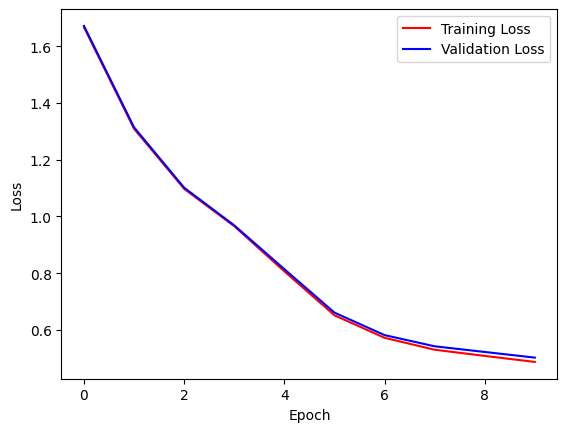

In [14]:
mlp.plot_loss()

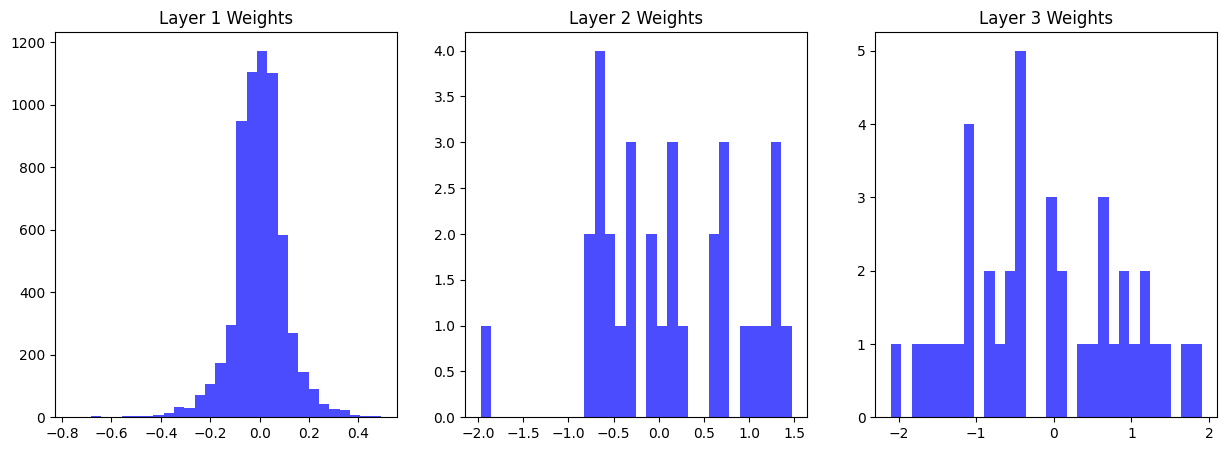

In [7]:
mlp.plot_weight_distribution()


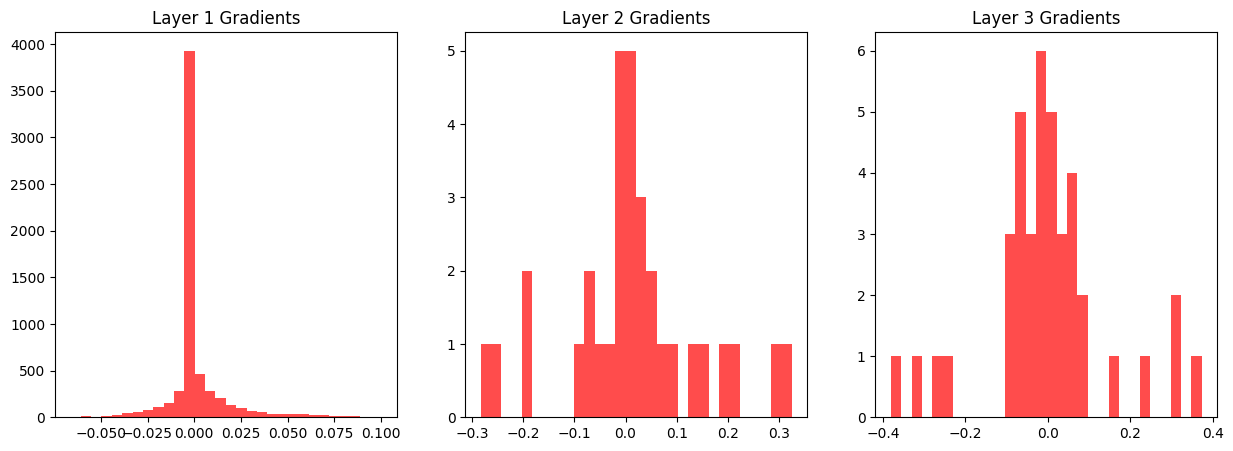

In [8]:
mlp.plot_gradient_distribution()

# Testing graph skala kecil

Training: 100%|██████████| 5/5 [00:00<00:00, 185.04epoch/s, accuracy=35.60%, train_loss=1.0979, val_loss=1.1000]

Test Accuracy: 29.00%


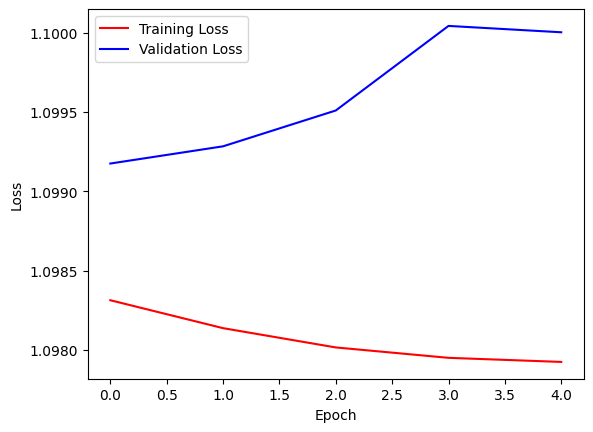

In [9]:

# Buat data random untuk testing
np.random.seed(42)
X_train = np.random.rand(500, 5)  # 500 sampel, 5 fitur (input layer)
y_train = np.eye(3)[np.random.choice(3, 500)]  # 500 label one-hot, 3 kelas

X_test = np.random.rand(100, 5)  # 100 sampel untuk validasi
y_test = np.eye(3)[np.random.choice(3, 100)]  # 100 label validasi

# Buat model MLP
input_layer = Layer(input_size=5, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_1 = Layer(input_size=8, n_neurons=8, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=8, n_neurons=4, activation='relu', bias_init='zeros', seed=42, weight_init='he_uniform')
output_layer = Layer(input_size=4, n_neurons=3, activation='softmax', bias_init='zeros', seed=42, weight_init='he_uniform')

layers = [input_layer, hidden_layer_1, hidden_layer_2, output_layer]

mlp = MLP(layers=layers, loss_function='cce', lr=0.1)

# Training model
mlp.train(X_train, y_train, X_val=X_test, y_val=y_test, epochs=5, batch_size=50)

# Evaluasi di test set
test_acc = mlp.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}%")

# Plot loss
mlp.plot_loss()

# Visualisasi arsitektur model
dot = draw_mlp(mlp)



In [ ]:
sample_size = 20

X_sample = X_test[:sample_size]
y_sample = y_test[:sample_size]

y_pred = mlp.predict(X_sample)

print(f"Dimensi y_pred: {y_pred.shape}")

if len(y_pred.shape) > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred 

y_true_labels = np.argmax(y_sample, axis=1)  

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_sample[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}", color="green" if y_true_labels[i] == y_pred_labels[i] else "red")
    ax.axis("off")

plt.tight_layout()
plt.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH